# Exercise 3

Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

## Load libraries

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import plotnine as p9 # ggplot2-like viz library

In [2]:
path_searches = "../Data/searches.csv.bz2"
path_cleaned_searches = "../Data/cleaned_searches.csv.bz2"
path_grouped_searches = "../Data/grouped_searches.csv"

## Load raw data in chunks

As the file is so big (460 MB) that it can't fit in the memory of my computer, I read it in chunks.

In [3]:
searches_iter = pd.read_csv(
    path_searches, 
    compression='bz2',
    engine='c',
    chunksize=500000,
    delimiter="^"
)

## Delete duplicates (only first time)

In [4]:
cleaned_searches = pd.DataFrame()

In [5]:
for searches_chunk in searches_iter:
    cleaned_searches = cleaned_searches.append(searches_chunk)
    cleaned_searches.drop_duplicates(inplace=True)

In [6]:
cleaned_searches.shape[0]

438240

In [19]:
(
    cleaned_searches
    .rename(columns=str.strip)
    .apply(lambda col: col.str.strip() if col.dtypes == "object" else col)
    .convert_dtypes()
    .to_csv(path_cleaned_searches, sep="^", index=False)
)


## Cleaned data at once

**Plan action**
1. Load cleaned data in one big chunk
2. Filter by *airport*: (AGP, BCN, MAD)
3. Manipulate columns: 
    - create *Month* column from Date column and convert it into integer
    - convert *Destination* into category data type
4. Group by *airport* and *month*
5. Count
6. Plot

### Step 1: Load cleaned data


In [20]:
searches = pd.read_csv(
    path_cleaned_searches,
    compression='bz2',
    engine='c',
    delimiter="^",
    usecols=["Date", 'Destination'],
    parse_dates=["Date"],
    dtype={'Destination':'string'},
)

### Step 2-5: Filter, manipulate columns, group and count

In [21]:
airports = ["AGP","BCN","MAD"]

searches_per_month = (
    searches
    .dropna()
    .query('Destination in @airports')
    .assign(
        Month=searches['Date'].str.extract(r"^\d{4}-(\d{2})", expand=False).astype('int'),
        Destination=searches['Destination'].astype(CategoricalDtype(airports))
    )
    .groupby(['Month', 'Destination'], as_index=False)
    .agg(Searches=('Date','count'))
)

In [22]:
(
    searches_per_month
    .head().style.hide_index()
)

Month,Destination,Searches
1,AGP,254
1,BCN,774
1,MAD,642
2,AGP,147
2,BCN,497


### Step 6: Plot

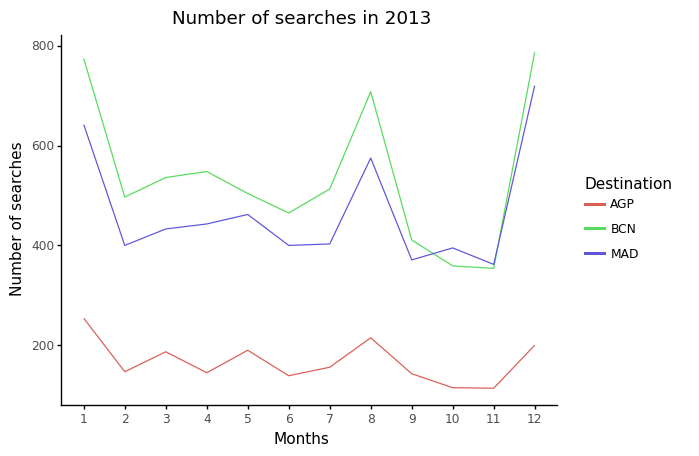

<ggplot: (155485970387)>

In [23]:
plot = (
    p9.ggplot(searches_per_month, p9.aes(x='Month', y='Searches', color='Destination'))
    + p9.geom_line()
    + p9.xlab("Months")
    + p9.ylab("Number of searches")
    + p9.ggtitle("Number of searches in 2013")
    + p9.scale_x_continuous(breaks=range(1,13))
    + p9.theme_classic()
)
plot

In [24]:
airports = ["AGP", "BCN", "MAD"]

(
    searches
    .dropna()
    .query('Destination in @airports')
    .assign(
        Month=searches['Date'].str.extract(r"^\d{4}-(\d{2})", expand=False).astype('int'),
        Destination=searches['Destination'].astype(CategoricalDtype(airports))
    )
    .pivot_table(
        index='Month',
        columns='Destination',
        values='Date',
        aggfunc='count'
    )
)

Destination,AGP,BCN,MAD
Month,,,
1,254,774,642
2,147,497,400
3,187,536,433
4,145,548,443
5,190,504,462
6,139,465,400
7,156,513,403
8,215,708,575
9,143,411,371


## Cleaned data in chunks

**Plan action**
1. Load cleaned data in chunks 
2. Loop over all chunks and save the result
    - Filter by *airport*: (AGP, BCN, MAD)
    - Manipulate columns: 
        - create **Month* column from Date column and convert it into integer
        - convert *Destination* into category data type
    - Group by *airport* and *Month*
    - Count
3. Manipulate the output of the previous step
    - Group by *airport* and *Month*
    - Sum 
4. Plot

### Step 1: Load cleaned data

In [13]:
searches_iter2 = pd.read_csv(
    path_cleaned_searches,
    compression='bz2',
    engine='c',
    chunksize=50000,
    delimiter="^",
    usecols=["Date", 'Destination'],
    dtype={'Destination':'string'},
)

### Step 2: Loop over all chunks

In [14]:
splited_searches_per_month = pd.DataFrame()

airports = ["AGP","BCN","MAD"]

for searches_chunk in searches_iter2:
    grp = (
        searches_chunk
        .dropna()
        .query('Destination in @airports')
        .assign(
            Month=searches['Date'].str.extract(r"^\d{4}-(\d{2})", expand=False).astype('int'),
            Destination=searches['Destination'].astype(CategoricalDtype(airports))
        )
        .groupby(['Month', 'Destination'], as_index=False)
        .agg(Searches = ('Date','count'))
    )

    splited_searches_per_month = splited_searches_per_month.append(grp, ignore_index=True)

### Step 3: Manipulate the result of the previous operation

In [15]:
searches_per_month2 =(
    splited_searches_per_month
    .groupby(['Month', 'Destination'], as_index=False)
    .agg(Searches = ('Searches', np.sum))
)

In [16]:
searches_per_month2.to_csv(path_grouped_searches)

### Step 4: Plot

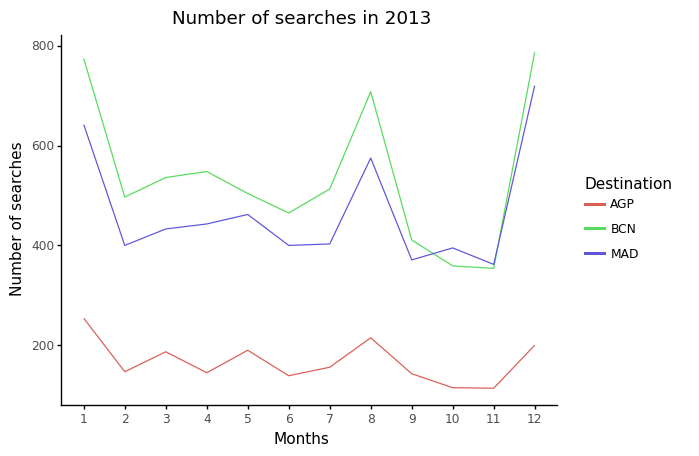

<ggplot: (155509237122)>

In [17]:
(
    p9.ggplot(searches_per_month2, p9.aes(x='Month', y='Searches', color='Destination'))
    + p9.geom_line()
    + p9.xlab("Months")
    + p9.ylab("Number of searches")
    + p9.ggtitle("Number of searches in 2013")
    + p9.scale_x_continuous(breaks=range(1,13))
    + p9.theme_classic()
)

In [27]:
p9.ggsave(plot, filename='Searches_per_month.png')

In [28]:
(
    searches_per_month2
    .pivot_table(
        index="Month",
        columns="Destination",
        aggfunc='sum',
        values="Searches"
    )
)

Destination,AGP,BCN,MAD
Month,,,
1,254,774,642
2,147,497,400
3,187,536,433
4,145,548,443
5,190,504,462
6,139,465,400
7,156,513,403
8,215,708,575
9,143,411,371
